# Code generation with RAG and self-corection

AlphaCodium presented an approach for code generation that uses control flow.

Main idea: [construct an answer to a coding question iteratively](https://x.com/karpathy/status/1748043513156272416?s=20)..

[AlphaCodium](https://github.com/Codium-ai/AlphaCodium) iteravely tests and improves an answer on public and AI-generated tests for a particular question.

We will implement some of these ideas from scratch using LangGraph:

1. We start with a set of documentation specified by a user
2. We use a long context LLM to ingest it and perform RAG to answer a question based upon it
3. We will invoke a tool to produce a structured output
4. We will perform two unit tests (check imports and code execution) prior returning the solution to the user

<img src='./images/code_assistant.png'>

## Setup

First, let's install our required packages and set the API keys we will need

In [1]:
# ! pip install -U langchain_community langchain-openai langchain-anthropic langchain langgraph bs4

In [2]:
import os
import keyring

# API KEY
OPENAI_API_KEY = keyring.get_password('openai', 'key_for_mac')
ANTHROPIC_API_KEY = keyring.get_password('anthropic', 'key_for_mac')
TAVILY_API_KEY = keyring.get_password('tavily', 'key_for_mac')

os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['ANTHROPIC_API_KEY'] = ANTHROPIC_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

# Set up LangSmith observability
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = "https://api.smith.langchain.com"
os.environ['LANGCHAIN_API_KEY'] = keyring.get_password('langsmith', 'learning_agent')
os.environ['LANGCHAIN_PROJECT'] = "pr-stupendous-hood-8"

## Docs

Load [LangChain Expression Language](https://python.langchain.com/docs/concepts/#langchain-expression-language-lcel) (LCEL) docs as an example.

In [3]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# LCEL docs
url = "https://python.langchain.com/docs/concepts/lcel/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Sort the list based on the URLs and get the text
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

## LLMs

### Code solution

First, we will try OpenAI and Claude3 with function calling.

We will create a `code_gen_chain` w/ either OpenAI or Claude and test them here.

In [5]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

### OpenAI

# Grader prompt
code_gen_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a coding assistant with expertise in LCEL, LangChain expression language. \n
            Here is a full set of LCEL documentation: \n ------ \n {context} \n ------ \n Answer the user
            question based on the above provided documentation. Ensure any code you provide can be executed \n
            with all required imports and variables defined. Structure your answer with a description of the code solution. \n
            Then list the imports. And finally list the functioning code block. Here is the user question:""",
        ),
        ("placeholder", "{messages}")
    ]
)

# Data model
class code(BaseModel):
    """Schema for code solution to questions about LCEL."""
    
    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block including import statements")
    
expt_llm = 'gpt-4o-mini'
llm = ChatOpenAI(model=expt_llm, temperature=0)
code_gen_chain_oai = code_gen_prompt | llm.with_structured_output(code)
question = "How do I builf a RAG chain in LCEL?"
solution = code_gen_chain_oai.invoke(
    {"context": concatenated_content, "messages": [("user", question)]}
)
solution

code(prefix='To build a Retrieval Augmented Generation (RAG) chain in LCEL, you will typically combine a retriever with a language model (LLM) and an output parser. The retriever fetches relevant documents based on a query, the LLM generates a response based on those documents, and the output parser formats the response. This can be achieved using the `RunnableSequence` to chain these components together. Below is an example of how to set this up.', imports='from langchain_core.runnables import RunnableSequence, RunnableParallel\nfrom langchain_core.runnables import LLM, Retriever, OutputParser', code='# Define the retriever, LLM, and output parser\nretriever = Retriever()  # Replace with actual retriever implementation\nllm = LLM()  # Replace with actual LLM implementation\noutput_parser = OutputParser()  # Replace with actual output parser implementation\n\n# Build the RAG chain using RunnableSequence\nrag_chain = RunnableSequence([\n    retriever,  # Step 1: Retrieve relevant docume

In [8]:
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate

### Anthropic
code_gen_prompt_claude = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """<instructions> You are a coding assistant with expertise in LCEL. LangChain expression language. \n
            Here is the LCEL documentation: \n ------ \n {context} \n ------ \n  Answer the user question based on the \n
            above provided documentation. Ensuare any code youn provide can be executed with all required imports and variabels \n
            defined. Structure your answer : 1) a prefix describing the code solution, 2) the imports, 3) the functioning code block. \n
            Invoke the code tool to structure the output correctly. <\Instructions> \n Here is the user question:""",
        ),
        ("placeholder", "{messages}"),
    ]
)

# LLM 
exp_llm = "claude-3-5-haiku-latest"
llm = ChatAnthropic(
    model=exp_llm,
    default_headers={"antropic-beta": "tools-2024-04-04"}
)

sturctured_llm_claude = llm.with_structured_output(code, include_raw=True)

# Optional: check for errors in case tool use in flaky
def chcek_claude_output(tool_output):
    """Check for parse error or failure to call the tool"""
    
    # Error with parsing
    if tool_output["parsing_error"]:
        # Report back output and parsing errors
        print("Parsing error!")
        raw_output = str(tool_output["raw"].content)
        error = tool_output["parsing_error"]
        raise ValueError(
            f"Error parsing your output! Be sure to invoke the tool. Output: {raw_output}. \n Parser error: {error}"
        )
    
    # Tool was not invoked
    elif not tool_output["parsed"]:
        print("Failed to invoke tool!")
        raise ValueError(
            "You did not use the provided tool! be sure to invoke the tool to structure the output."
        )
    return tool_output

# Chain with output check
code_chain_claude_raw = (
    code_gen_prompt_claude | sturctured_llm_claude | chcek_claude_output
)

def insert_error(inputs):
    """Insert errors for tool parsing in the messages"""
    
    # Get errors
    error = inputs["error"]
    messages = inputs["messages"]
    messages += [
        (
            "assistant",
            f"Retry. You are required to fix the parsing errors: {error} \n\n You must invoke the provided tool.",
        )
    ]
    return {
        "messages": messages,
        "context": inputs["context"],
    }

# This will be run as a fallback chain
fallback_chain = insert_error | code_chain_claude_raw
N = 3 # Max re-tries
code_gen_chain_re_try = code_chain_claude_raw.with_fallbacks(
    fallbacks=[fallback_chain] * N, exception_key="error"
)

def parse_output(solution):
    """When we add 'include_raw=True' to structured output,
    it will return a dict w 'raw', 'parsed', 'parsing_error'."""
    
    return solution["parsed"]

# Optional : With re-try to correct for failure to invoke tool
code_gen_chain = code_gen_chain_re_try | parse_output

# No re-try
code_gen_chain = code_gen_prompt_claude | sturctured_llm_claude | parse_output

In [9]:
# Test
question = "How do I build a RAG chain in LCEL?"
solution = code_gen_chain.invoke(
    {"context": concatenated_content, "messages": [("user", question)]}
)
solution

code(prefix='This example demonstrates building a Retrieval Augmented Generation (RAG) chain using LangChain Expression Language (LCEL). The chain will:\n1. Use a document loader to load documents\n2. Create text splitter to chunk documents\n3. Create embeddings for vector storage\n4. Create a vector store retriever\n5. Create a prompt template for RAG\n6. Use a chat model to generate responses\n7. Combine these components into a RAG chain', imports='from langchain_community.document_loaders import TextLoader\nfrom langchain_text_splitters import RecursiveCharacterTextSplitter\nfrom langchain_community.embeddings import OllamaEmbeddings\nfrom langchain_community.vectorstores import Chroma\nfrom langchain_core.runnables import RunnablePassthrough\nfrom langchain_core.prompts import ChatPromptTemplate\nfrom langchain_community.chat_models import ChatOllama', code='# Load documents\nloader = TextLoader("sample_document.txt")\ndocs = loader.load()\n\n# Split documents into chunks\ntext_spl

## State

Our state is a dict that will contain keys (errors, question, code generation) relevant to code generation.

In [10]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """ 
    Represents the state of out graph.
    
    Attributes:
        error: Binary flag for control flow to indicate whether test error was tripped
        messages: With user question, error messages, reasoning
        generation: Code solution
        iterations: Number of tries
    """
    
    error: str
    messages: List
    generation: str
    iterations: int

## Graph

Our graph lays out the logical flow shown in the figure above.

In [14]:
### Parameter

# Max tries
max_iterations = 3
# Reflect
# flag = 'reflect' 
flag = 'do not reflect'

### Nodes

def generate(state: GraphState):
    """ 
    Generate a code solution
    
    Args:
        state (dict): The current graph state
    
    Returns:
        state (dict): New key added to state, generation
    """
    
    print("---GENERATION CODE SOLUTION---")
    
    # State
    messages = state["messages"]
    iterations = state["iterations"]
    error = state["error"]
    
    # We have been routed back to generation with an error
    if error == "yes":
        messages += [
            (
                "user",
                "Now, try again. Invoke the code tool to structure the output with a prefix, import, and code block:",
            )
        ]
    
    # Solution
    code_solution = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [
        (
            "assistant",
            f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}",
        )
    ]
    
    # Increment
    iterations = iterations + 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations}

def code_check(state: GraphState):
    """ 
    Check code
    
    Args:
        state (dict): The current graph state
    
    Returns:
        state (dict): New key added to state, error 
    """
    
    print("---CHECKING CODE---")
    
    # State
    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]
    
    # Get solution components
    imports = code_solution.imports
    code = code_solution.code
    
    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the import test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }
        
    # No errors
    print("---NO CODE TEST FAILURES---")
    return {
        "generation": code_solution,
        "messages": messages,
        "iterations": iterations,
        "error": "no",
    }
    
def reflect(state: GraphState):
    """ 
    Reflect on errors
    
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, generation
    """
    
    print("---GENERATION CODE SOLUTION---")
    
    # State
    messages = state["messages"]
    iterations = state["iterations"]
    code_solution = state["generation"]
    
    # Prompt reflection
    
    # Add reflection
    reflections = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [("assistant", f"Here are reflections on the error: {reflections}")]
    return {"generation": code_solution, "messages": messages, "iterations": iterations}

### Edges

def decide_to_finish(state: GraphState):
    """
    Determines whether to finish
    
    Args:
        state (dict): The current graph state
        
    Returns:
        str: Next node to call
    """
    error = state["error"]
    iterations = state["iterations"]
    
    if error == 'no' or iterations == max_iterations:
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        if flag == "reflect":
            return "reflect"
        else:
            return "generate"

In [16]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("generate", generate)     # generate solution
workflow.add_node("check_code", code_check) # check code
workflow.add_node("reflect", reflect)       # reflect

# Buold graph
workflow.add_edge(START, "generate")
workflow.add_edge("generate", "check_code")
workflow.add_conditional_edges(
    "check_code",
    decide_to_finish,
    {
        "end": END,
        "reflect": "reflect",
        "generate": "generate",
    }
)
workflow.add_edge("reflect", "generate")
app = workflow.compile()

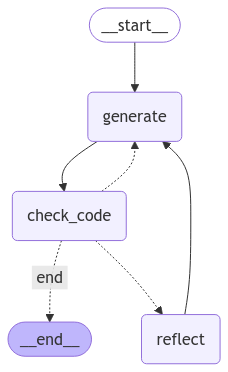

In [17]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [19]:
question = "How can I directly pass a string to a runnable and use it to contruct the input needed for my prompt?"
soltution = app.invoke({"messages": ["user", question], "iterations": 0, "error": ""})

---GENERATION CODE SOLUTION---
---CHECKING CODE---
---NO CODE TEST FAILURES---
---DECISION: FINISH---


In [20]:
soltution["generation"]

code(prefix="This example demonstrates how to directly pass a string to a runnable and use it to construct input for a prompt template in LCEL. We'll show how to use string coercion and function conversion to easily create input for a prompt.", imports='from langchain_core.prompts import PromptTemplate\nfrom langchain_core.runnables import RunnableLambda\nfrom langchain_openai import ChatOpenAI', code='# Create a prompt template\nprompt = PromptTemplate.from_template("Tell me a {type} joke about {subject}")\n\n# Create a language model\nllm = ChatOpenAI(model="gpt-3.5-turbo")\n\n# Create a chain that transforms a simple string input\n# This demonstrates how you can directly pass a string and transform it\ndef prepare_joke_input(subject):\n    return {"type": "silly", "subject": subject}\n\n# Construct the chain using LCEL composition\njoke_chain = RunnableLambda(prepare_joke_input) | prompt | llm\n\n# Invoke the chain with a direct string input\nresult = joke_chain.invoke("programming"

## Eval

[Here](https://smith.langchain.com/public/326674a6-62bd-462d-88ae-eea49d503f9d/d?paginationState=%7B%22pageIndex%22%3A0%2C%22pageSize%22%3A10%7D) is a public dataset of LCEL questions.

I saved this as lcel-teacher-eval.

You can also find the csv [here](https://github.com/langchain-ai/lcel-teacher/blob/main/eval/eval.csv).

In [21]:
import langsmith

client = langsmith.Client()

In [22]:
# Clone the dataset to your tenant to use it
try:
    public_dataset = (
        "https://smith.langchain.com/public/326674a6-62bd-462d-88ae-eea49d503f9d/d"
    )
    client.clone_public_dataset(public_dataset)
except:
    print("Please setup LangSmith")

### Custom evals.

In [24]:
from langsmith.schemas import Example, Run

def check_import(run: Run, example: Example) -> dict:
    imports = run.outputs.get("imports")
    try:
        exec(imports)
        return {"key": "import_check", "score": 1}
    except Exception:
        return {"key": "import_check", "score": 0}
    
def check_execution(run: Run, example: Example) -> dict:
    imports = run.outputs.get("imports")
    code = run.outputs.get("code")
    try:
        exec(imports + "\n" + code)
        return {"key": "code_execution_check", "score": 1}
    except Exception:
        return {"key": "code_execution_check", "score": 0}

### Compare LangGraph to Context Stuffing.

In [28]:
def predict_base_case(example: dict):
    """Context stuffing"""
    solution = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": [("user", example["question"])]}
    )
    return {"imports": solution.imports, "code": solution.code}

def predict_langgraph(example: dict):
    """LangGrpah"""
    graph = app.invoke(
        {"messages": [("user", example["question"])], "iterations": 0, "error": ""}
    )
    solution = graph["generation"]
    return {"imports": solution.imports, "code": solution.code}

In [29]:
from langsmith.evaluation import evaluate

# Evaluator
code_evaluator = [check_import, check_execution]

# Dataset
dataset_name = "lcel-teacher-eval"

In [30]:
# Run base case
try:
    experimental_results_ = evaluate(
        predict_base_case,
        data=dataset_name,
        evaluators=code_evaluator,
        experiment_prefix=f"test-without-langgraph-{exp_llm}",
        max_concurrency=2,
        metadata={
            "llm": exp_llm
        }
    )
except:
    print("Please setup LangSmith")

View the evaluation results for experiment: 'test-without-langgraph-claude-3-5-haiku-latest-b4ebd342' at:
https://smith.langchain.com/o/1002547c-0a48-4fe3-9a6d-802598ca95d3/datasets/47840fd5-365d-4ae6-b17c-21c0309f99c3/compare?selectedSessions=31eb5553-adb4-42d5-a8c8-920a4512f90f




2it [00:12,  5.08s/it]

content='Why do programmers prefer dark mode?\n\nBecause the light attracts bugs!' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 14, 'total_tokens': 28, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-67c99244-6edc-440c-9438-a7938104aff0-0' usage_metadata={'input_tokens': 14, 'output_tokens': 14, 'total_tokens': 28, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


4it [00:20,  4.39s/it]<string>:25: LangChainDeprecationWarning: The class `OpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAI``.
7it [00:33,  4.27s/it]

Why do programmers prefer dark mode? Because the light attracts bugs!
Machine learning is a subset of artificial intelligence that involves developing algorithms and statistical models that allow computers to learn from and make predictions or decisions based on data. It is a method of data analysis that automates analytical model building. 

In machine learning, computers are trained to recognize patterns in data without being explicitly programmed to do so. Instead, they learn from examples and experience, adjusting their algorithms and models to improve their performance over time. This is typically achieved through the use of algorithms that can analyze and interpret data, identify patterns, and make decisions or predictions based on those patterns.

There are several different types of machine learning algorithms, including supervised learning, unsupervised learning, and reinforcement learning. Supervised learning involves training a model on labeled data, where the correct answer

8it [00:39,  4.95s/it]

messages=[HumanMessage(content='Translate the following question to italian: where did harrison work', additional_kwargs={}, response_metadata={})]


10it [00:44,  3.61s/it]

name='John Doe' age=30 hobbies=['reading', 'hiking', 'painting']
Name: John Doe
Age: 30
Hobbies: ['reading', 'hiking', 'painting']


11it [00:49,  4.14s/it]<string>:13: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/


<class 'langchain_core.utils.pydantic.PromptInput'>

# Detailed schema representation:
{'properties': {'adjective': {'title': 'Adjective', 'type': 'string'}}, 'required': ['adjective'], 'title': 'PromptInput', 'type': 'object'}


12it [00:50,  3.11s/it]

itemgetter result: What is LCEL?
lambda result: What is LCEL?
get() result: What is LCEL?
itemgetter raises KeyError when key is missing
lambda raises KeyError when key is missing

get() method: None
get() method with default: No question


13it [00:56,  4.02s/it]

content="Why couldn't the bicycle stand up by itself?\n\nBecause it was two-tired!" additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 12, 'total_tokens': 30, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-4f52b1d4-77c1-46bb-a22c-6af30a9be808-0' usage_metadata={'input_tokens': 12, 'output_tokens': 18, 'total_tokens': 30, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
<class 'str'>


16it [01:23,  7.40s/it]

Approach 1 result:
content="Why couldn't the bicycle stand up by itself? Because it was two tired!" additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 22, 'total_tokens': 39, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-de554645-73b0-41f3-bba8-fff127cf936f-0' usage_metadata={'input_tokens': 22, 'output_tokens': 17, 'total_tokens': 39, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
<class 'langchain_core.messages.ai.AIMessage'>
"HELLO WORLD" is a common phrase used in computer programming to test the output of a program or to demonstrate a basic functionality. It is typically used as the first p

18it [01:29,  5.46s/it]

{'first_result': 'Processed first chain: Hello, parallel processing!', 'second_result': 'Processed second chain: Hello, parallel processing!'}


20it [01:31,  4.58s/it]


Results:

- `LangGraph outperforms base case`: adding re-try loop improve performance
- `Reflection did not help`: reflection prior to re-try regression vs just passing errors directly back to the LLM
- `GPT-4 outperforms Claude3`: Claude3 had 3 and 1 run fail due to tool-use error for Opus and Haiku, respectively